# Intorduction
In this notebook I will work on the MNIST data set containing handwritten digits. The original data set contains 60 000 training images and 10 000 test images. However, I am using the Kaggle data set, which has 42 000 training images (and presumably 28 000 test images).

Each image consists of 28x28 greyscale pixels in the range [0, 255].

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

First, lets have a look at some examples from the training set.

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


TypeError: text() missing 2 required positional arguments: 'y' and 's'

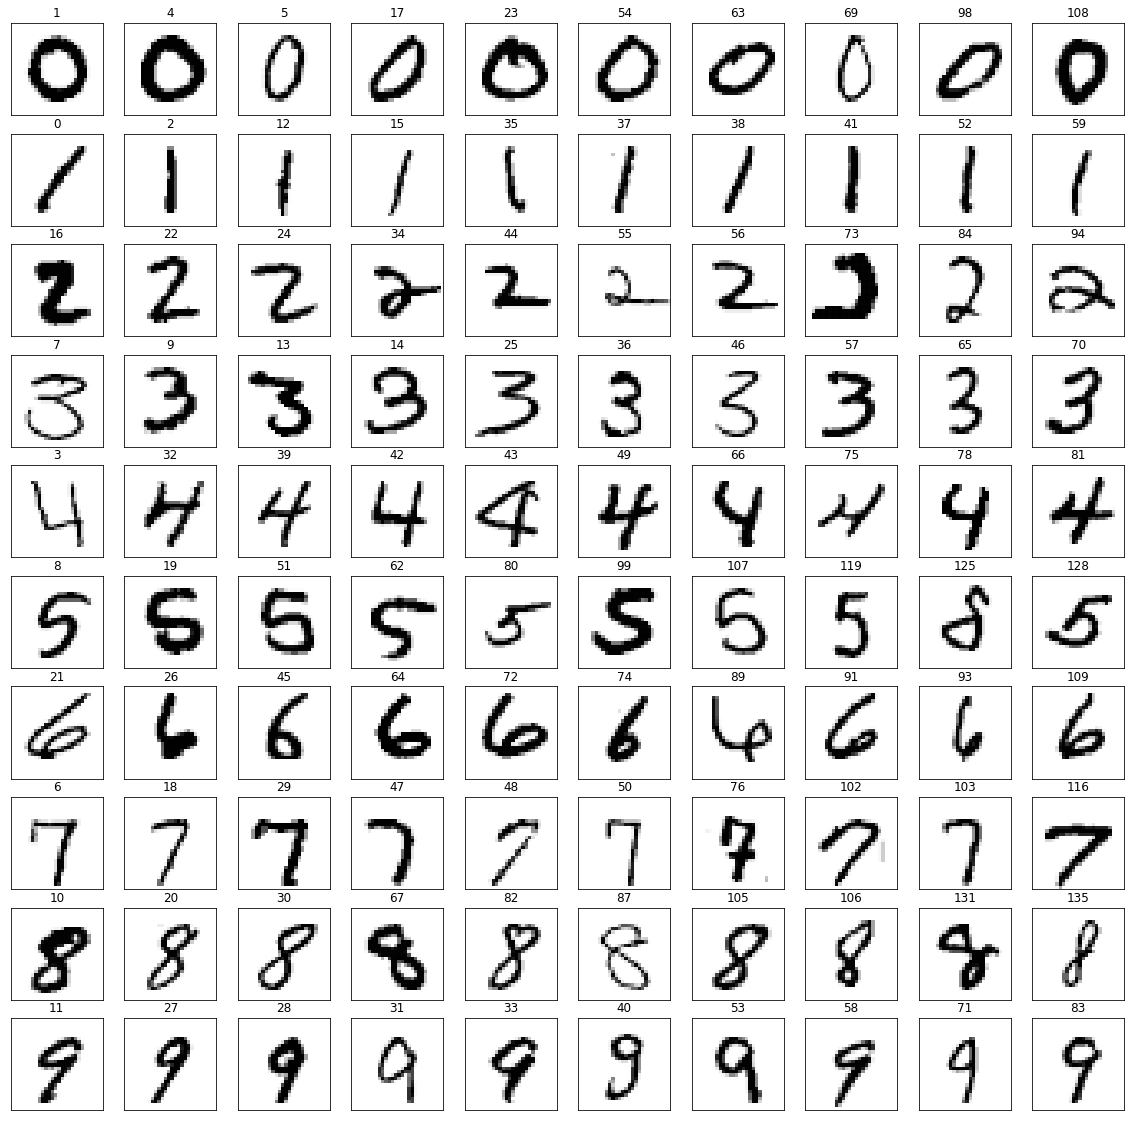

In [53]:
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    digit = df[df['label'] == i//10].iloc[i%10]
    f= plt.imshow(digit.iloc[1:].values.reshape(28,28), cmap='Greys')
    f.axes.set_title(digit.name)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

Most images are pretty clear, but some will definitely cause problems. Have a look at the 5 with index 125 for example:



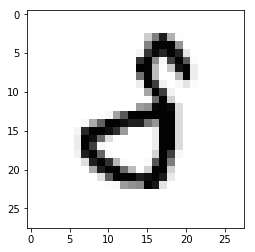

In [57]:
plt.subplots(figsize=(4,4))
digit = df.iloc[125]
f= plt.imshow(digit.iloc[1:].values.reshape(28,28), cmap='Greys')

In my oppinion this would be hard to classify for a human. But let's get back to these problematic images later.

I would like to reduce the complexity of the images before attempting to classify them. Right now each iamge consists of 28x28 discrete features, that is 784 features.

I would like to simplify the features in two major ways:
* I don't belive there is real value to having each feature take a discrete value in the range [0,255], I am pondering simplifying to a binary [0,1] or maybe just reducing the amount of intermediate values a lot. The idea is that shapes are more important than color nuances.
* Most importantly, I would like to analyse general shapes instead of every pixel. Some ideas:
    * Count "holes", isolated islands of white. An eight should have two, a six one etc. Of course there are exceptions, such as the five above and some fours etc.
    * Simplify the image to line segments.


Lets start out simple though. First I will classify the unprocessed images using a Random Forest Classifier to get a benchmark. As my focus is not on machine learning models in this notebook I will use an out of the box Scikit-Learn model.

# No modifications
The first step I need to take is to convert my data to numpy arrays, as this is what scikit-learn models take as inputs.

In [166]:
labels = df['label'].values

In [9]:
digits = df.iloc[:,1:].values

In [10]:
# Lets start with Stochastic Gradient Descent which should be able to handle the large amount of features well (compared to the closed form solution of linear regression)
from sklearn.linear_model import SGDClassifier

In [11]:
sgd = SGDClassifier(random_state=0)
sgd.fit(digits, labels)

C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(labels, sgd.predict(digits))

0.88797619047619047

So just using linear regression on the raw input data get's us 88.7% accracy on the training set. I don't think a linear classifier will do well without any feature engineering though.

Let's also try a Random Forest Calssifier.

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
random_forest = RandomForestClassifier(random_state = 0)

In [98]:
random_forest.fit(digits, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [99]:
accuracy_score(labels, random_forest.predict(digits))

0.99895238095238093

Wow, thats better! The Random Forest Classifier succesfully fits the training set and gets 99.9% accuracy. Let's get a better estimate of it's potential using cross validation though, as 99.9% accuracy signals we might be over fitting.

In [173]:
from sklearn.model_selection import cross_val_score

In [101]:
no_features_acc = cross_val_score(random_forest, digits, labels, cv=10, scoring='accuracy')

array([ 0.93984784,  0.93958135,  0.93669681,  0.93739586,  0.93880952,
        0.93712789,  0.932603  ,  0.94233977,  0.94470925,  0.94041945])

In [106]:
no_features_acc.mean()

0.93895307400000017

That's more reasonable! We have our baseline.

# Binarizing intensities
Let's binarize all color intensities. Let's explore what cutoff intensity we should use.

In [124]:
def describe_intensity(digit):
    digit = np.extract(digit > 0, digit)
    return digit.min(), digit.max(), digit.mean()

In [125]:
describe_intensity(digits[0])

(7, 255, 171.63917525773195)

In [126]:
intensity = np.apply_along_axis(describe_intensity, 1, digits)

In [135]:
print("Lowest minimum intensity: {}".format(intensity[:,0].min()))
print("Maximum minimum intensity: {}".format(intensity[:,0].max()))
print("Lowest Maximum intensity: {}".format(intensity[:,1].min()))
print("Mean intensity: {}".format(intensity[:,2].mean()))


Lowest minimum intensity: 1.0
Maximum minimum intensity: 255.0
Lowest Maximum intensity: 254.0
Mean intensity: 172.55689107765986


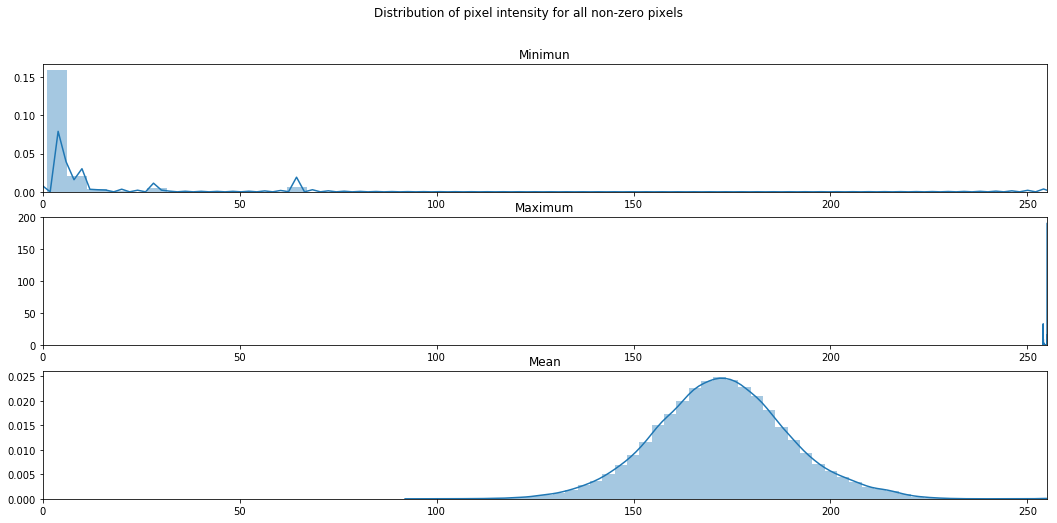

In [149]:
f, ax = plt.subplots(3, 1, figsize=(18,8))
titles = ['Minimun', 'Maximum', 'Mean']
sns.distplot(intensity[:,0], ax=ax[0])
sns.distplot(intensity[:,1], ax=ax[1])
sns.distplot(intensity[:,2], ax=ax[2])
for i in range(len(ax)):
    ax[i].set_xlim(0, 255)
    ax[i].set_title(titles[i])
f.suptitle('Distribution of pixel intensity for all non-zero pixels')

Okay, so we have lots of pixels quite a bit below the maximum intensity. It's hard to tell at what intensity I should set my cutoff at though. Let's try some experimenting!

In [152]:
def binarize_digit(digit, cutoff):
    black = np.full(28*28, 255)
    white = np.full(28*28, 0)
    mask = digit >= cutoff
    return np.where(mask, black, white)

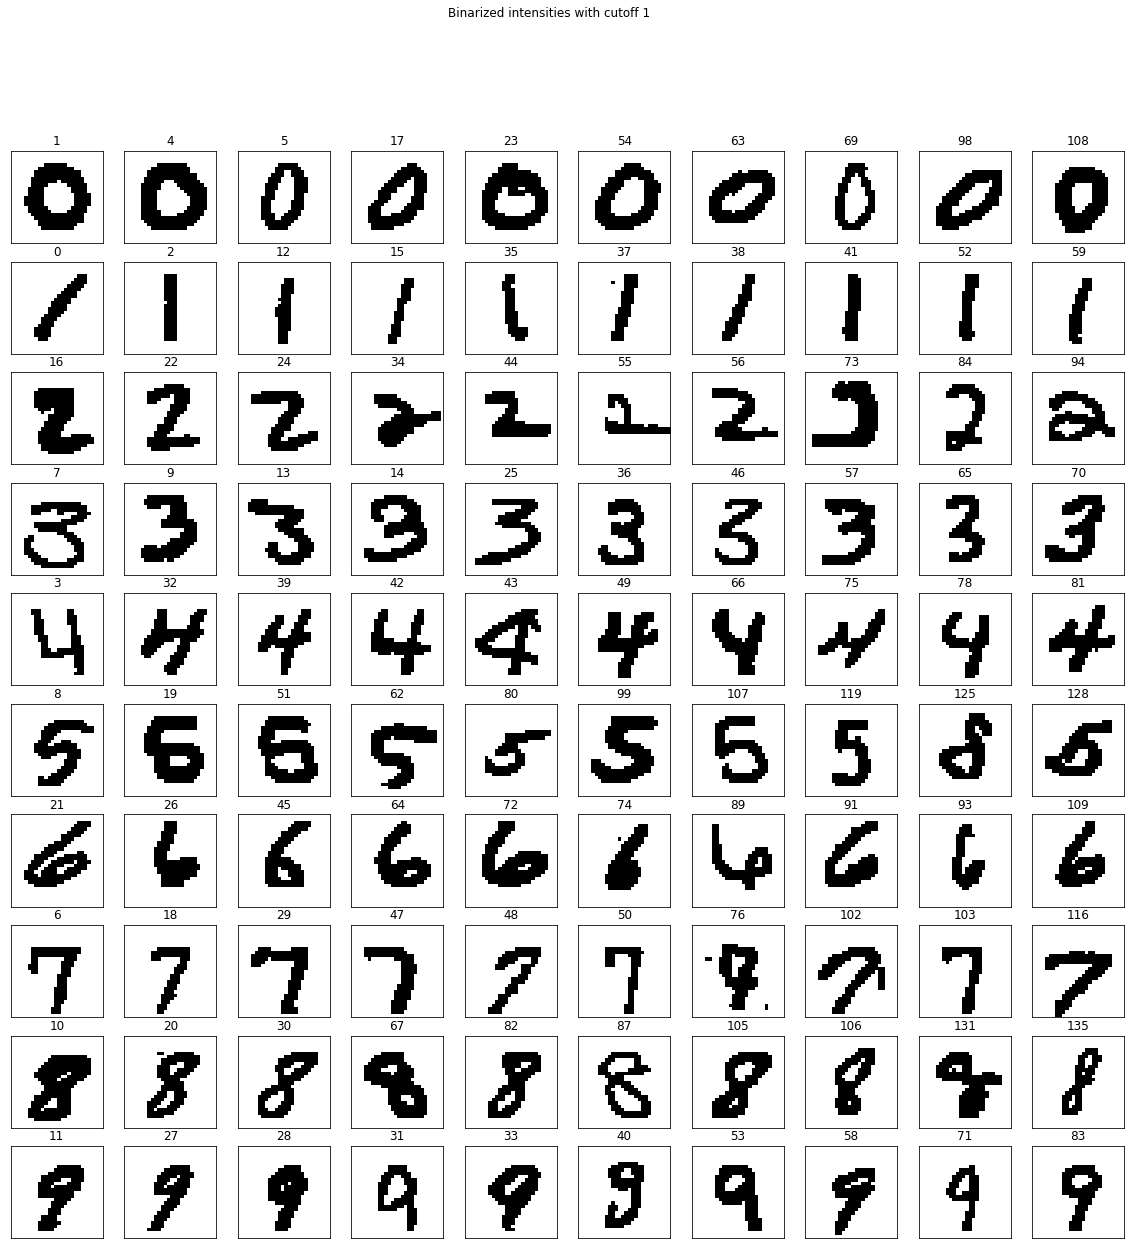

In [158]:
cutoff = 1
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    digit = df[df['label'] == i//10].iloc[i%10]
    index = digit.name
    digit = digit.iloc[1:]
    digit = binarize_digit(digit, 1)
    f= plt.imshow(digit.reshape(28,28), cmap='Greys')
    f.axes.set_title(index)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
plt.suptitle("Binarized intensities with cutoff {}".format(cutoff))

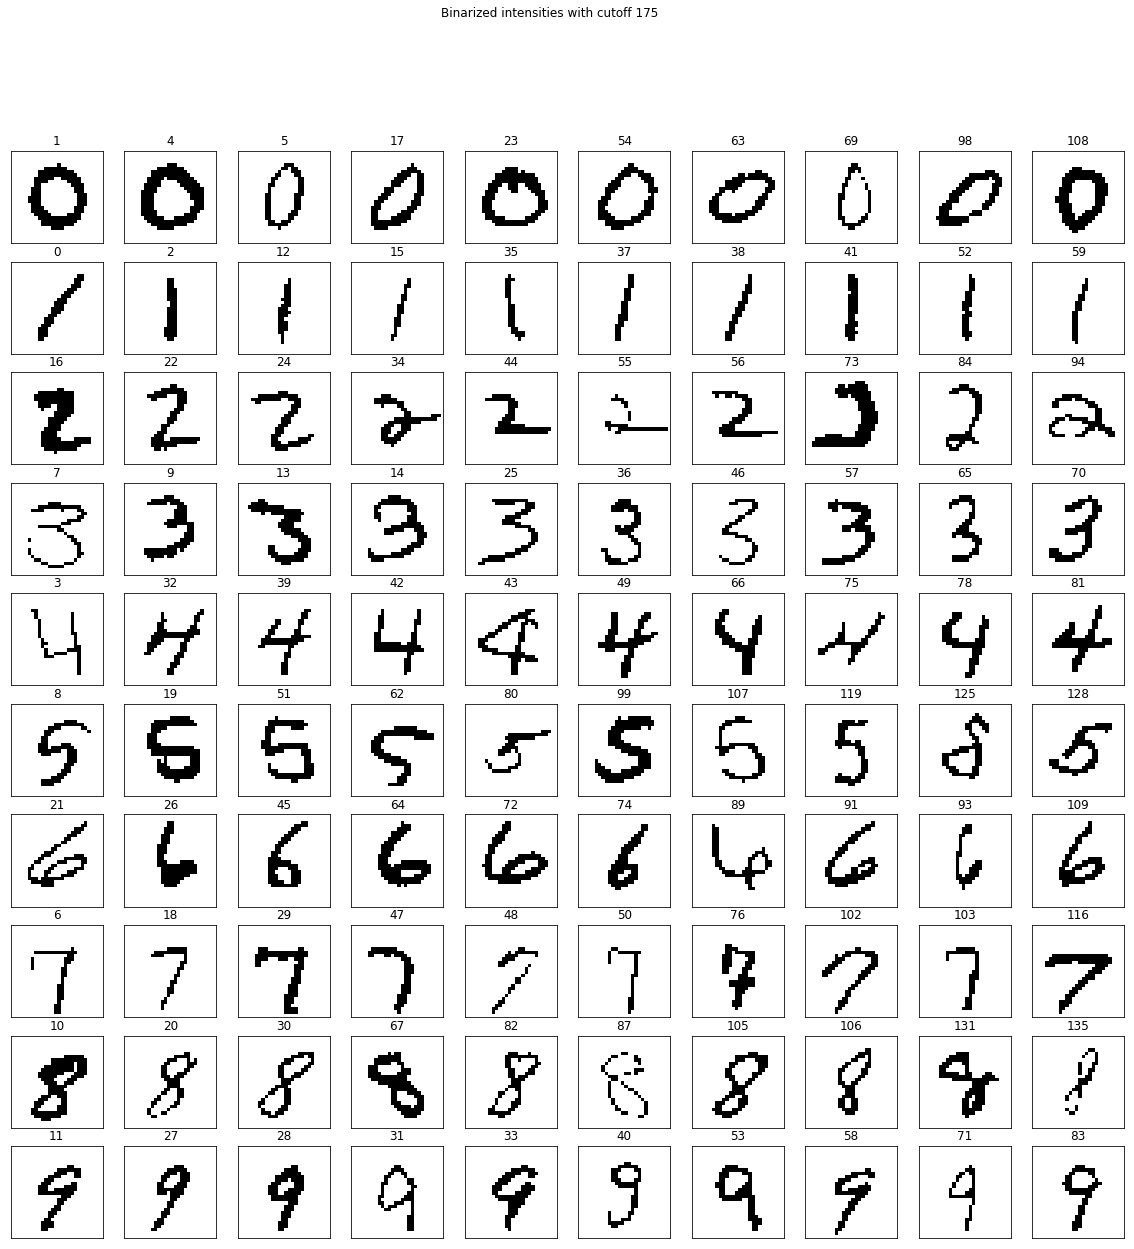

In [160]:
cutoff = 175
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    digit = df[df['label'] == i//10].iloc[i%10]
    index = digit.name
    digit = digit.iloc[1:]
    digit = binarize_digit(digit, cutoff)
    f= plt.imshow(digit.reshape(28,28), cmap='Greys')
    f.axes.set_title(index)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
plt.suptitle("Binarized intensities with cutoff {}".format(cutoff))

In [161]:
def binarize_digit_func(digit, cutoff_func):
    black = np.full(28*28, 255)
    white = np.full(28*28, 0)
    mask = digit >= cutoff_func(digit)
    return np.where(mask, black, white)

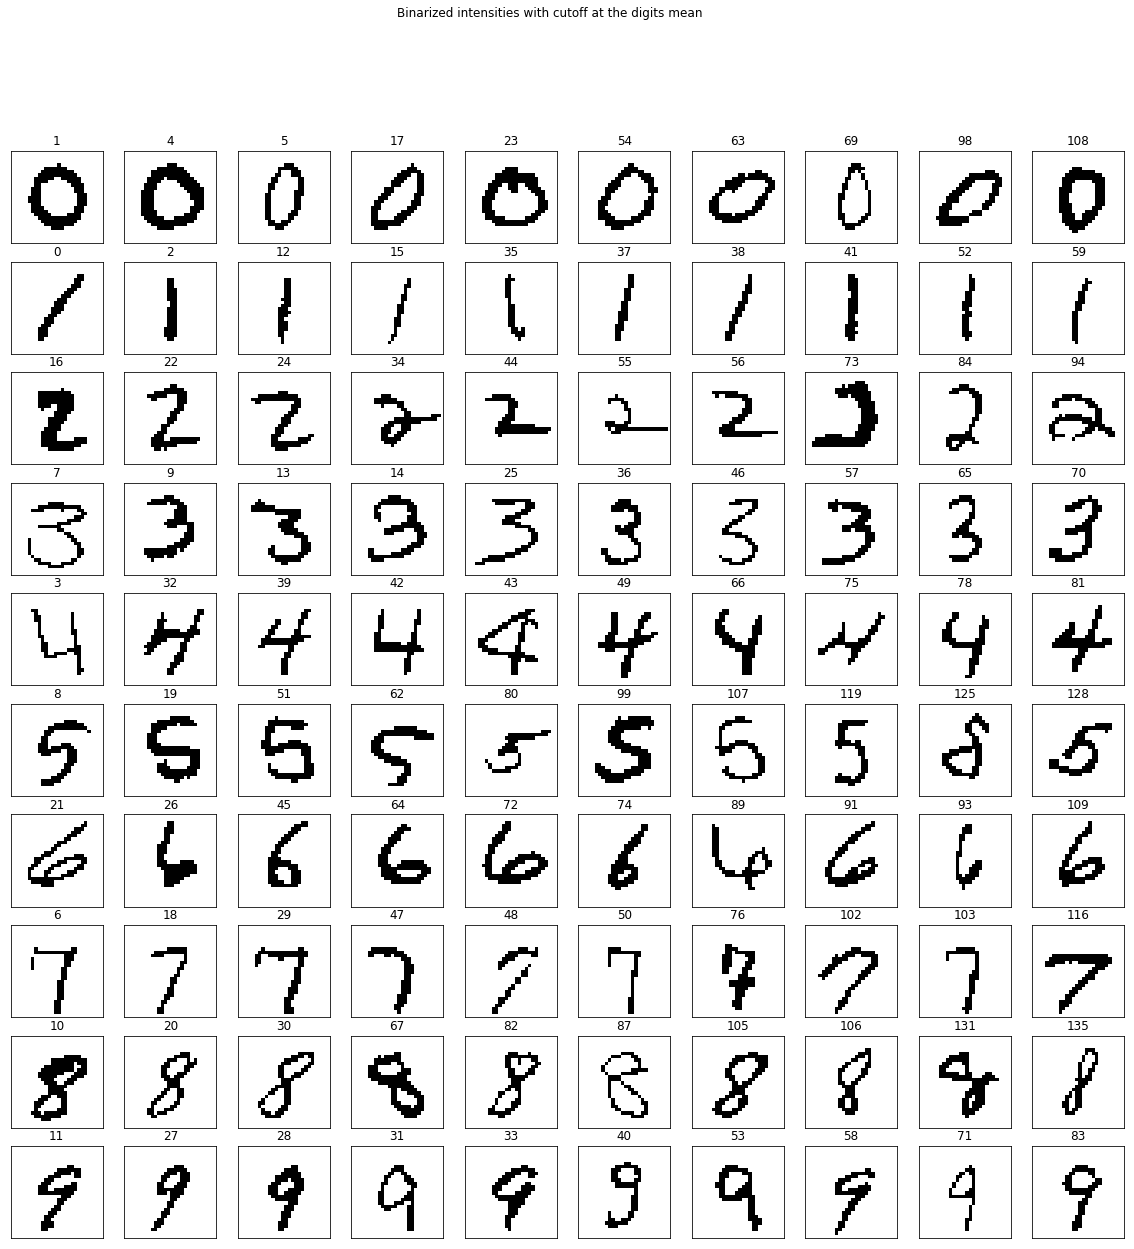

In [163]:
cutoff = lambda x: np.extract(digit > 0, digit).mean()
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    digit = df[df['label'] == i//10].iloc[i%10]
    index = digit.name
    digit = digit.iloc[1:]
    digit = binarize_digit_func(digit, cutoff)
    f= plt.imshow(digit.reshape(28,28), cmap='Greys')
    f.axes.set_title(index)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
plt.suptitle("Binarized intensities with cutoff at the digits mean")

I think using the mean looks somewhat potent, although it does make some digits disjoint. Let's see how it affect our accuracy!

In [155]:
from sklearn.base import BaseEstimator, TransformerMixin



class DigitBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, cutoff = lambda x: np.extract(x > 0, x).mean()):
        self.cutoff = cutoff
    def fit(self, X, y = None):
        return self
    def transform(self, X, y= None):
        return np.apply_along_axis(self.binarize_digit_inner, 1, X)
    def binarize_digit_inner(self, digit):
        # This time we actually binarize the digit
        black = np.full(28*28, 1)
        white = np.full(28*28, 0)
        cutoff_c = self.cutoff(digit)
        mask = digit >= cutoff_c
        return np.where(mask, black, white)
        

In [144]:
binarizer = DigitBinarizer()

In [145]:
binarized_digits = binarizer.transform(digits)

In [7]:
binarized_features_acc = cross_val_score(random_forest, binarized_digits, labels, cv=10, scoring='accuracy')

NameError: name 'cross_val_score' is not defined

In [179]:
binarized_features_acc.mean()

0.9216661360809667

Slightly lower accuracy than we got on the unprocessed digits. Let's look at some examples where we got it wrong.

In [17]:
from sklearn.model_selection import cross_val_predict

In [18]:
predicted = cross_val_predict(random_forest, binarized_digits, labels, cv=10)

In [19]:
wrong_prediction = predicted != labels

In [20]:
# Number of failed predictions
wrong_prediction.sum()

3290

In [21]:
(len(wrong_prediction) - wrong_prediction.sum() )/ len(wrong_prediction)

0.92166666666666663

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
cnf_mat = confusion_matrix(labels, predicted)

In [24]:
cnf_mat

array([[4032,    1,   18,   10,    1,   12,   42,    3,   10,    3],
       [   1, 4606,   24,   13,    4,    9,    8,    8,    7,    4],
       [  49,   21, 3829,   41,   39,   24,   32,   61,   59,   22],
       [  18,   14,  110, 3937,   10,  117,    5,   31,   67,   42],
       [  13,   20,   29,    9, 3777,    9,   38,   17,   22,  138],
       [  47,   17,   35,  163,   42, 3364,   41,   13,   40,   33],
       [  68,   12,   22,    9,   14,   51, 3935,    2,   18,    6],
       [  15,   40,   71,   23,   54,   11,    1, 4088,   13,   85],
       [  29,   37,  107,  126,   49,  103,   52,   18, 3464,   78],
       [  33,   11,   35,   71,  176,   46,    8,   83,   47, 3678]], dtype=int64)

In [25]:
np.fill_diagonal(cnf_mat, 0)

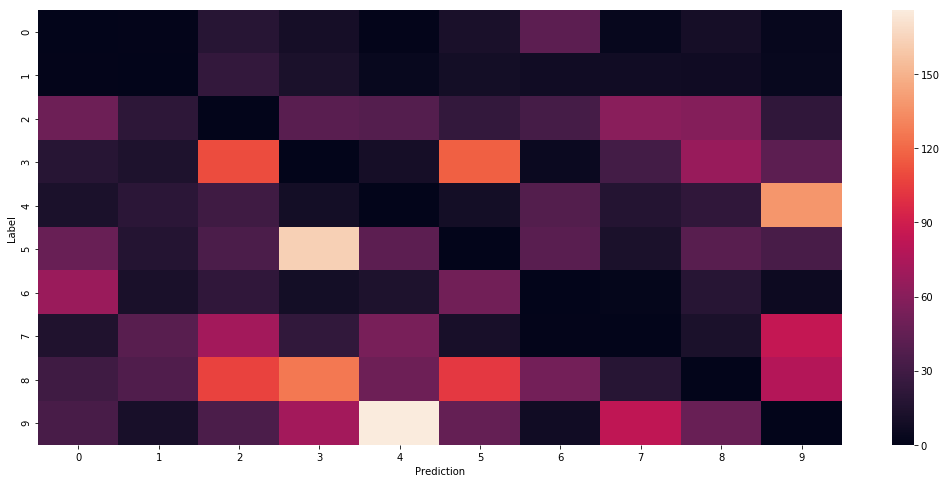

In [26]:
f, ax = plt.subplots(figsize=(18,8))
sns.heatmap(cnf_mat, ax=ax)
ax.set_ylabel('Label')
ax.set_xlabel('Prediction')

So our worst mistakes seem to be classifying 9's as 4's, 5's as 3's and 4's as 9's.

Let's see what the digits we fail on look like. I will copy the method used in `Hands-On Machine Learning with Scikit-Learn & TensorFlow` as I found it very informative!

In [27]:
cl_a, cl_b = 4, 9

In [28]:
# Digits correctly predicted as class a
X_aa = binarized_digits[(labels == cl_a) & (predicted == cl_a)]
# Digits labeld as class a predicted as class b
X_ab = binarized_digits[(labels == cl_a) & (predicted == cl_b)]
# Etc.
X_ba = binarized_digits[(labels == cl_b) & (predicted == cl_a)]
X_bb = binarized_digits[(labels == cl_b) & (predicted == cl_b)]

In [87]:
def plot_digits(X, digits_per_row, x_offset = 0, y_offset = 0, color = 'black'):
    for y in range(digits_per_row):
        for x in range(digits_per_row):
            plt.subplot(digits_per_row*2, digits_per_row*2, (y+y_offset)*(digits_per_row*2) + x + x_offset + 1)
            f = plt.imshow(X[y*digits_per_row + x].reshape(28,28), cmap='Greys')
            for spine in f.axes.spines.values():
                spine.set_edgecolor(color)
            #f.figure.edgecolor(color)
            f.axes.get_xaxis().set_visible(False)
            f.axes.get_yaxis().set_visible(False)
            #ax[y+y_offset][x+x_offset].set_xticks([])
            #ax[y+y_offset][x+x_offset].set_yticks([])

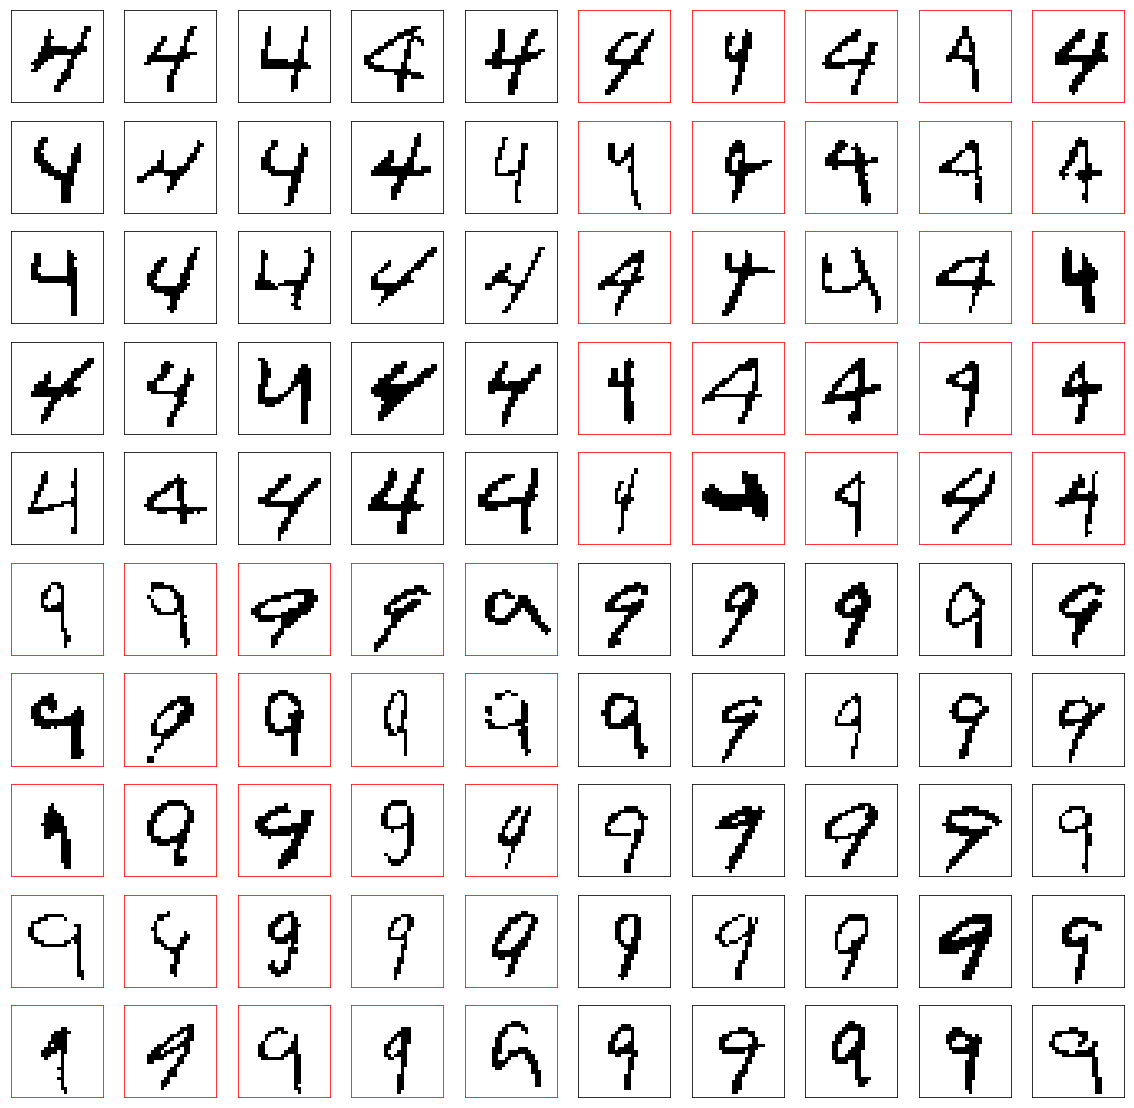

In [90]:
#f, ax = plt.subplots(25, 25, figsize = (18,18))
plt.figure(figsize=(20, 20))
plot_digits(X_aa[:25], 5)
plot_digits(X_ab[:25], 5, x_offset=5, color = 'red')
plot_digits(X_ba[:25], 5, y_offset=5, color='red')
plot_digits(X_bb[:25], 5, x_offset=5, y_offset=5)

## Tune cutoff
Let's explore some different cutoff's.

In [99]:
binarizer_50 = DigitBinarizer(cutoff = lambda x:  50)

In [100]:
binarized_digits_50 = binarizer_50.transform(digits)

In [171]:
cutoffs = [lambda x:  50, lambda x:  75, lambda x:  100, lambda x:  125, lambda x:  150, lambda x:  175, lambda x:  200, lambda x:  225, lambda x:  250]
binarizers =  [DigitBinarizer()] + [DigitBinarizer(cutoff=cutoff) for cutoff in cutoffs]
binarized_digits_cutoffs = [binarizer.transform(digits) for binarizer in binarizers]
binarized_digits_cutoffs = [digits] + binarized_digits_cutoffs

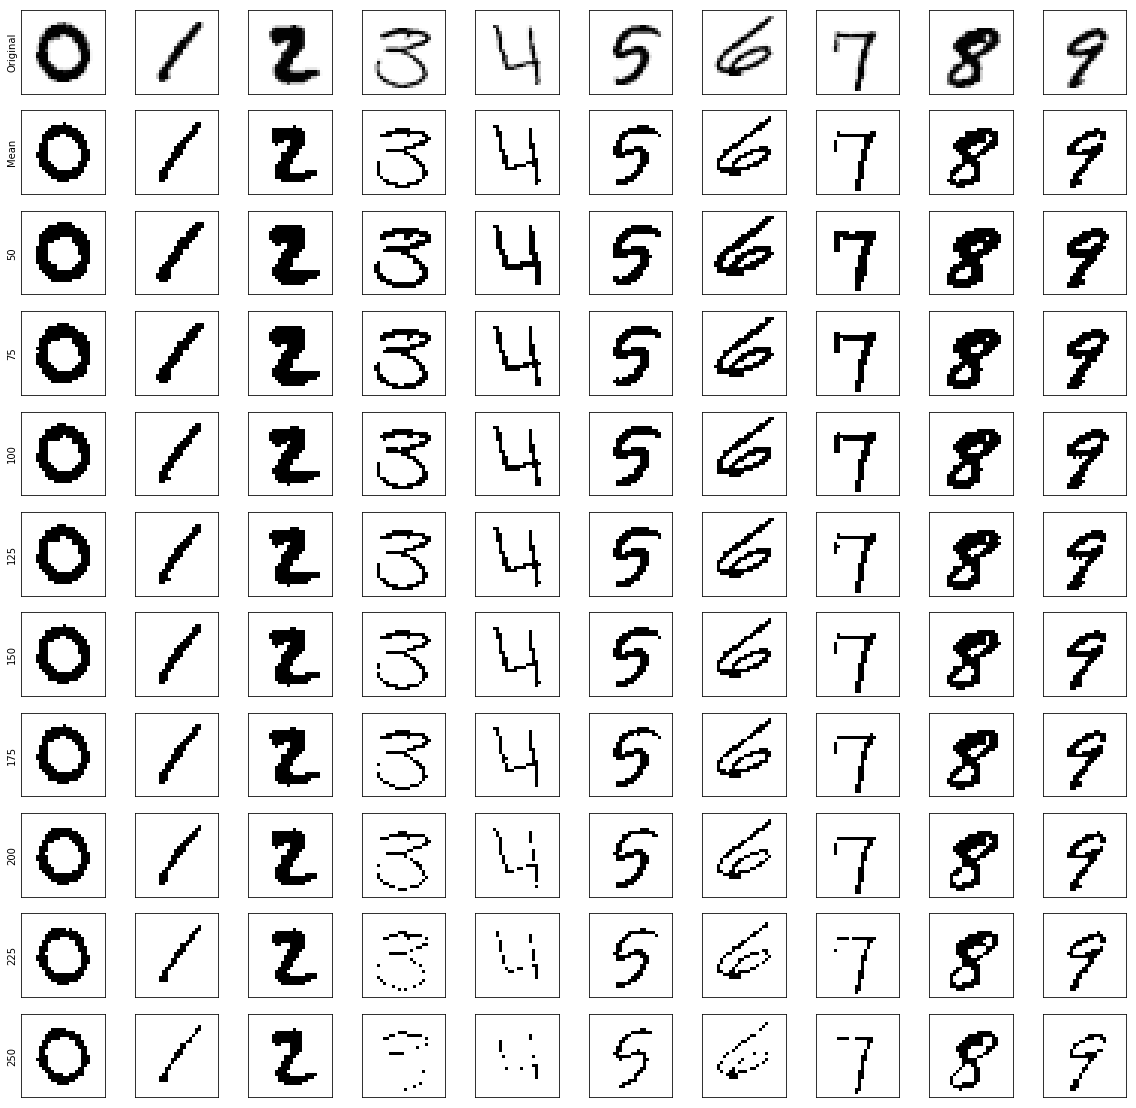

In [172]:
ylabels = ['Original', 'Mean'] + [f(1) for f in cutoffs]
n_cutoffs = len(binarized_digits_cutoffs)

plt.figure(figsize=(20,20))
for i in range(10 * n_cutoffs):
    plt.subplot(n_cutoffs, 10, i + 1)
    f = plt.imshow(binarized_digits_cutoffs[i//10][labels == i%10][0].reshape(28,28), cmap='Greys')
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_ticks([])
    if(i%10 == 0):
        f.axes.set_ylabel(ylabels[i//10])

The effect of an increased cutoff is as expected. We se fewer black pixels. Let's see what accuracy we get on these different sets of features:

In [174]:
acc_arr = [cross_val_score(random_forest, features, labels, cv=10, scoring='accuracy') for features in binarized_digits_cutoffs]

In [178]:
for cutoff, acc in zip(ylabels, acc_arr):
    print("{}, accuracy: {}, standard deviation: {}".format(cutoff, acc.mean(), acc.std()))

Original, accuracy: 0.9389530729300153, standard deviation: 0.0031486470289333788
Mean, accuracy: 0.9216661360809667, standard deviation: 0.003528141349274289
50, accuracy: 0.9432867882046727, standard deviation: 0.004812018713047504
75, accuracy: 0.941547880749947, standard deviation: 0.0031628624127144015
100, accuracy: 0.9369529309648289, standard deviation: 0.00410927162526723
125, accuracy: 0.9315002622808191, standard deviation: 0.004952989040970388
150, accuracy: 0.9247398159012239, standard deviation: 0.004786993128189384
175, accuracy: 0.9145246003511225, standard deviation: 0.0034948879915212452
200, accuracy: 0.9023807170366759, standard deviation: 0.0036464811428795246
225, accuracy: 0.8839994991275075, standard deviation: 0.004392396421500637
250, accuracy: 0.8377394611105684, standard deviation: 0.004715026423754498


Looks like a low cutoff might give the best results. After all, that keeps the information about all pixels touched by the artist while still simplifying the features by binarizing them.

In [179]:
binarizer1 = DigitBinarizer(cutoff=lambda x: 1)

In [180]:
binarized1_digits = binarizer1.transform(digits)

In [181]:
score1 = cross_val_score(random_forest, binarized1_digits, labels, cv=10, scoring='accuracy')

In [182]:
print("{}, accuracy: {}, standard deviation: {}".format(1, score1.mean(), score1.std()))

1, accuracy: 0.9451440903748025, standard deviation: 0.0033718092921674616


Setting the cutoff at 1 actually get's the best accuracy. Let's use that and move on.

In [184]:
random_forest.fit(binarized1_digits, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [185]:
test = pd.read_csv('test.csv')

In [188]:
test = test.values

In [190]:
predictions = random_forest.predict(test)

In [195]:
len(predictions)

28000

In [212]:
submission_df = pd.DataFrame(list(zip(np.arange(1, 28001), predictions)), columns = ['ImageID', 'Label'])

In [213]:
submission_df.set_index('ImageID').to_csv('submission1.csv')

# Reducing the number of features - 
I think the much more interesting and important aspect of our feature engineering process is reducing the amount of features, not reducing their ranges.



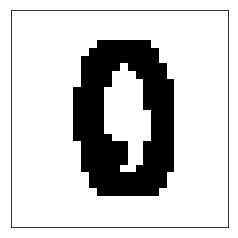

In [221]:
f = plt.imshow(binarized1_digits[1881].reshape(28,28), cmap='Greys')
f.axes.get_xaxis().set_visible(False);
f.axes.get_yaxis().set_ticks([]);